<h1 align='center'> Нейронные сети в PyTorch для классификации изображений 

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

## Данные MNIST

Воспользуемся встроенным в PyTorch набором изображений рукописных цифр с разрешением 28x28.

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 109347898.54it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 80918967.15it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24722303.67it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18406307.99it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Индексация и визуализация набора данных
---

Мы можем индексировать наборы данных вручную, как список: `training_data[index]`. Мы используем `matplotlib` для визуализации некоторых выборок в наших обучающих данных.

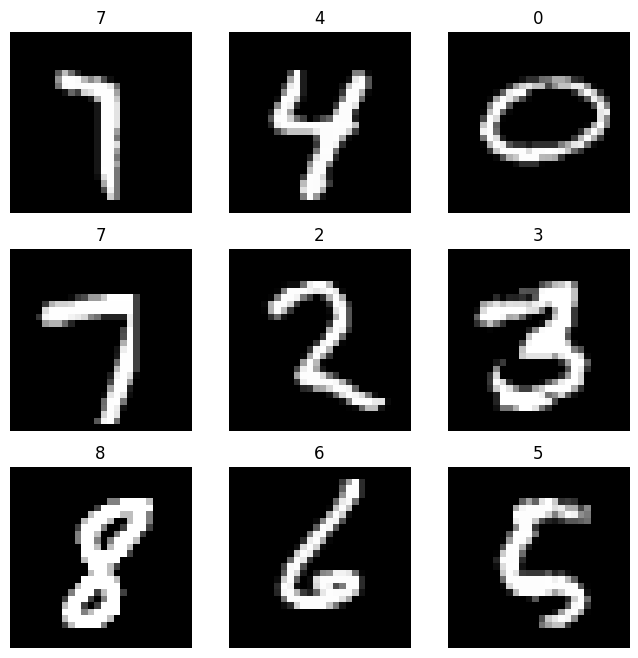

In [3]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Coздание загрузчика данных средствами Fastai


In [4]:
!pip install fastbook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [5]:
import fastbook
fastbook.setup_book()
from fastbook import *

Mounted at /content/gdrive


Функции загрузки, проверки и очистки изображений
----
Давайте воспользуемся загрузкой файлов из интернета при помощи функции `download_url()`, и откроем при помощи `Image.open()`. В визуализации нам поможет функция `to_thumb()` из модуля `fastai.vision`.   

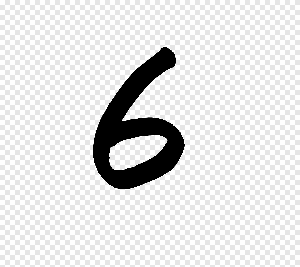

In [6]:
link=['https://e7.pngegg.com/pngimages/173/894/png-clipart-logo-brand-number-design-white-text.png']
dest = 'images/six.jpg'
download_url(link[0], dest)
im = Image.open(dest)
im.to_thumb(300,300)

Теперь используем URL, не содержащий изображения, и попробуем сохранить его как изображение в туже папку под именем six1.jpg. Для получения списка путей к файлам в папке с изображениями можно использовать функцию `get_image_files()` модуля `fastai.data.transform`.

In [7]:
link1=['https://habr.com/ru/company/wunderfund/blog/314242/']
dest1 = 'images/six1.jpg'
download_url(link1[0], dest1)
img = get_image_files('images')
img

(#2) [Path('images/six1.jpg'),Path('images/six.jpg')]

Очевидно, файл six1.jpg не является изображением, проверить это можно при помощи функции `verify_image()` из модуля `fastai.vision.utils`. Функция выведет список ошибочных файлов.

In [8]:
failed = verify_images(img)
failed

(#1) [Path('images/six1.jpg')]

Чтобы удалить все неудачные изображения, вы можете использовать разорвать связь на каждом из них. Обратите внимание, что, как и большинство функций fastai, возвращающих коллекцию, `verify_images()` возвращает объект типа `L`, который включает метод `map`. Этот метод вызывает переданную функцию для каждого элемента коллекции:

In [9]:
failed.map(Path.unlink)
img = get_image_files('images')
img

(#1) [Path('images/six.jpg')]

In [10]:
path = untar_data(URLs.MNIST)/'training'
num_img=get_image_files(path)
num_img

(#60000) [Path('/root/.fastai/data/mnist_png/training/4/22105.png'),Path('/root/.fastai/data/mnist_png/training/4/20251.png'),Path('/root/.fastai/data/mnist_png/training/4/14496.png'),Path('/root/.fastai/data/mnist_png/training/4/26855.png'),Path('/root/.fastai/data/mnist_png/training/4/50069.png'),Path('/root/.fastai/data/mnist_png/training/4/3183.png'),Path('/root/.fastai/data/mnist_png/training/4/30702.png'),Path('/root/.fastai/data/mnist_png/training/4/58613.png'),Path('/root/.fastai/data/mnist_png/training/4/11144.png'),Path('/root/.fastai/data/mnist_png/training/4/3417.png')...]

In [11]:
failed = verify_images(num_img)
failed

(#0) []

Загрузчики данных
-----

Далее вы также узнаете о fastai классах `Dataset` и `Datasets`, которые имеют одинаковые отношения.

Чтобы превратить наши загруженные данные в объект `Dataloader`, нам нужно определить как минимум четыре вещи:

- С какими видами данных мы работаем
- Как получить список элементов
- Как пометить эти элементы
- Как создать поверочный набор

До сих пор мы видели ряд методов `fastai` для определенных комбинаций этих вещей, которые удобны, когда у вас есть приложение и структура данных, которые случайно вписываются в эти предопределенные методы. Для тех случаев, когда вы этого не делаете, `fastai` имеет чрезвычайно гибкую систему, называемую API блоков данных. С помощью этого API вы можете полностью настроить каждый этап создания ваших загрузчиков данных. Вот что нам нужно, чтобы создать загрузчики данных для набора данных, который мы только что загрузили:

In [12]:
mnist = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(28))

Давайте рассмотрим каждый из этих аргументов по очереди. Сначала мы предоставляем кортеж, в котором мы указываем, какие типы мы хотим для независимых и зависимых переменных:

```python
blocks=(ImageBlock, CategoryBlock)
```

*Независимая переменная* - это то, что мы используем для составления прогнозов, а *зависимая переменная* - наша цель. В этом случае нашими независимыми переменными являются изображения, а нашими зависимыми переменными являются категории (тип цифры) для каждого изображения. 

Для этих `DataLoaders` нашими базовыми элементами будут пути к файлам. Необходимо указать `DataBlock`, как получить список этих файлов. Функция `get_image_files()` принимает путь и возвращает список всех изображений в этом пути (рекурсивно, по умолчанию):

```python
get_items=get_image_files()
```

Часто загружаемые наборы данных уже имеют набор данных проверки. Иногда это делается путем размещения изображений для обучающих и проверочных наборов в разные папки. Иногда это делается путем предоставления CSV-файла, в котором указано каждое имя файла вместе с набором данных, в котором оно должно находиться. Есть много способов, которыми это можно сделать, и `fastai` предоставляет очень общий подход, который позволяет вам использовать для этого один из своих предопределенных классов или написать свой собственный. В этом случае, однако, мы просто хотим разделить наши обучающие и проверочные наборы случайным образом. Тем не менее, мы хотели бы иметь одинаковое разделение обучения/проверки при каждом запуске этой записной книжки, поэтому мы исправляем случайное начальное число(если вы каждый раз предоставляете одну и ту же отправную точку для этого списка, называемую *seed*, то каждый раз вы будете получать один и тот же список):


```python
splitter=RandomSplitter(valid_pct=0.2, seed=42)
```
Независимую переменную часто называют `x`, а зависимую переменную часто называют `y`. Здесь мы сообщаем fastai, какую функцию вызывать для создания меток в нашем наборе данных:

```python
get_y=parent_label
```

`parent_label` - это функция, предоставляемая fastai, которая просто находит имя папки, в которой находится файл. Поскольку мы помещаем каждое из наших изображений цифр в папки в зависимости от цифры, это даст нам нужные метки.

Изображения могут быть разного размера, и это проблема для глубокого обучения: мы подаем модели не по одному изображению за раз, а несколько из них (то, что мы называем *мини-пакетом*). Чтобы сгруппировать их в большой массив (обычно называемый *тензором*), который будет проходить через нашу модель, все они должны быть одинакового размера. Итак, можно добавить преобразование, которое изменит размер этих изображений до того же размера. *Преобразования элементов* - это фрагменты кода, которые выполняются для каждого отдельного элемента, будь то изображение, категория или так далее. fastai включает в себя множество предопределенных преобразований; здесь можно использовать преобразование изменяющее размер  `Resize`:

```python
item_tfms=Resize(28)
```

Но поскольку набор данных MNIST содержит изображения одинакового разрешения нам это не понадобится. Команда дала нам объект `DataBlock`. Это похоже на *шаблон* для создания `DataLoaders`. Нам все еще нужно сообщить fastai фактический источник наших данных — в данном случае путь, по которому можно найти изображения:

In [14]:
dls = mnist.dataloaders(path)

`DataLoaders` включают в себя загрузчики данных для проверки и обучения. `DataLoaders` - это класс, который предоставляет графическому процессору пакеты из нескольких элементов одновременно. Когда вы просматриваете загрузчик данных, `fastai` будет выдавать вам 64 (по умолчанию) элемента за раз, все они собраны в один тензор. Мы можем взглянуть на некоторые из этих элементов, вызвав метод `show_batch` в `DataLoaders`:

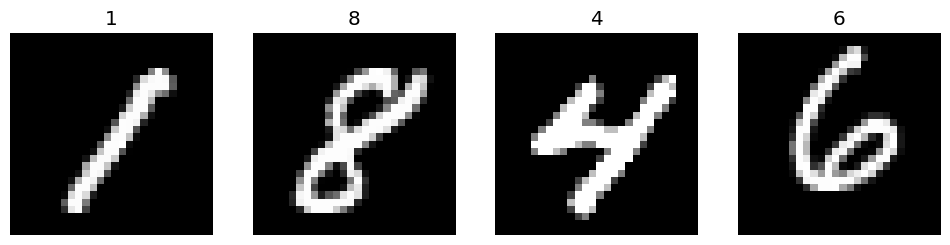

In [15]:
dls.valid.show_batch(max_n=4, nrows=1)

## Вернемся к тензорам

Сначала давайте создадим модель, не используя ничего, кроме тензорных операций Pytorch. PyTorch предоставляет методы для создания случайных или заполненных нулем тензоров, которые мы будем
использовать для создания наших весов и смещения для простой линейной модели. Это просто обычные тензоры, с одним очень специальным дополнением: мы говорим PyTorch, что им требуется
градиент. Это заставляет PyTorch записывать все операции, выполняемые с тензором, чтобы он мог автоматически вычислять градиент во время обратного распространения.
<div class="alert alert-info"><h4>Примечание:</h4><p>Мы инициализируем веса, используя
   <a href='http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf'>инициализацию Xavier Glorot</a> (умножая на 1/sqrt(n)).</p></div>

In [16]:
import math

weights = torch.randn(28*28, 10) / math.sqrt(28*28)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Благодаря способности PyTorch автоматически вычислять градиенты, мы можем использовать любую стандартную функцию Python (или вызываемый объект) в качестве модели! Итак, давайте просто напишем простое матричное умножение и broadcast сложение, чтобы создать простую линейную модель. Нам также нужна функция активации, поэтому мы напишем `log_softmax` и будем ее использовать. Помните: хотя PyTorch предоставляет множество предварительно написанных функций потери, функций активации и т. д., Вы можете легко написать свои собственные, используя обычный python. PyTorch даже автоматически создаст быстрый GPU или векторизованный GPU код для вашей функции.

In [17]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

В приведенном выше примере `@` означает операцию `.dot`. Мы вызовем нашу функцию на одном пакете данных (в данном случае 64 изображения). Это один проход вперед. Обратите внимание, что на данном этапе наши прогнозы будут не лучше случайных, так как мы начинаем со случайных весов.

In [18]:
bs = 64  # размер пакета
xb=torch.zeros(bs,28*28)
yb=torch.zeros(bs)
for i in range(bs):
    img_b,target_b = training_data[i]# мини-пакет из x
    xb[i,:]=img_b.view(1,-1)
    yb[i]=target_b

preds = model(xb)  # предсказания
preds[0], preds.shape
print(preds[0], preds.shape)
print(yb)

tensor([-2.0200, -2.2622, -2.7712, -2.5609, -2.4867, -2.3719, -2.5162, -2.2697, -2.2454, -1.8520], grad_fn=<SelectBackward0>) torch.Size([64, 10])
tensor([5., 0., 4., 1., 9., 2., 1., 3., 1., 4., 3., 5., 3., 6., 1., 7., 2., 8., 6., 9., 4., 0., 9., 1., 1., 2., 4., 3., 2., 7., 3., 8., 6., 9., 0., 5., 6., 0., 7., 6., 1., 8., 7., 9., 3., 9., 8., 5.,
        9., 3., 3., 0., 7., 4., 9., 8., 0., 9., 4., 1., 4., 4., 6., 0.])


Тензор `preds` содержит не только значения тензора, но и функцию градиента. Мы воспользуемся этим позже, чтобы сделать обратное распространение ошибки.

Давайте перекодируем целевую переменную, так чтобы ее можно было сравнивать с предсказанием модели, используем кодирование One-hot. Проверим его для значения 4.

In [19]:
target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).
                        scatter_(0, y.type(torch.int64), value=1))
target_transform(torch.tensor(5))

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

Поскольку `taget_transform` преобразует тензор-число в тензор-вектор, для пакета целевых переменных необходимо сформировать тензор-матрицу размера 10x64

In [20]:
target_b=torch.vstack([target_transform(t) for t in yb])
target_b[:5,:], target_b.shape

(tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]),
 torch.Size([64, 10]))

Давайте реализуем отрицательную логарифмическую вероятность для использования в качестве функции потерь (опять же, мы можем просто использовать стандартный Python):

In [21]:
def nll(input, target):
    return (-input*target).mean()

loss_func = nll

Посмотрим подробнее как работает функция nll().

In [22]:
import numpy as np

inp_vec=torch.tensor(np.arange(0,1,0.1))
tag=target_transform(torch.tensor(5))
print(inp_vec[range(tag.shape[0])]*tag)
print(inp_vec)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000], dtype=torch.float64)
tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000], dtype=torch.float64)


Задание 1.
---
Обратите внимание, что сумма компонент вектора `inp_vec` не равна 1, в этом смысле он не может быть сформирован в модели логистической регрессии. Какую функцию необходимо использовать для того, чтобы преобразовать компоненты к виду вектора вероятности? Преобразуйте этот вектор к вектору вероятности. 

In [23]:
inp_vec = torch.div(inp_vec, torch.sum(inp_vec))

print(inp_vec)
print(inp_vec.sum())

tensor([0.0000, 0.0222, 0.0444, 0.0667, 0.0889, 0.1111, 0.1333, 0.1556, 0.1778, 0.2000], dtype=torch.float64)
tensor(1., dtype=torch.float64)


Давайте проверим ошибку нашей случайной модели

In [24]:
print(loss_func(preds, target_b))

tensor(0.2306, grad_fn=<MeanBackward0>)


Реализуем функцию для расчета точности нашей модели. Для каждого прогноза, если индекс с наибольшим значением соответствует целевому значению, то прогноз был правильным.

In [25]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

Давайте проверим точность нашей случайной модели, чтобы увидеть, улучшается ли наша точность по мере увеличения потерь.

In [26]:
print(accuracy(preds, yb))

tensor(0.1094)


Теперь мы можем запустить цикл обучения. Для каждой итерации мы будем:

- выберать мини-пакет данных (размером `bs`)
- использовать модель для составления прогнозов
- рассчитывать потери
- `loss.backward()` обновляет градиенты модели, в данном случае `weights`
и `bias`.

Теперь мы используем эти градиенты для обновления весов и смещения. Мы делаем это в контекстном менеджере `torch.no_grad ()`, потому что мы не хотим, чтобы эти действия были записаны для нашего следующего вычисления градиента. Вы можете прочитать
больше о том, как Autograd PyTorch записывает операции <a href='https://pytorch.org/docs/stable/notes/autograd.html'>здесь </a>.

Затем мы устанавливаем градиенты равными нулю, чтобы быть готовыми к следующему циклу. В противном случае наши градиенты записали бы текущий подсчет всех выполненных операций (т. е. `loss.backward()` *добавляет* градиенты ко всему, что уже сохранено, а не заменяет их).

.. Совет:: Вы можете использовать стандартный отладчик python для пошагового выполнения PyTorch код, позволяющий проверять различные значения переменных на каждом шаге. Раскомментируйте `set_trace()` ниже, чтобы попробовать.

In [27]:
from IPython.core.debugger import set_trace

lr = 0.5  # скорость обучения
epochs = 2  # количество эпох
bs = 64 # количество данных в пакете

for epoch in range(epochs):
    for i in range((training_data.__len__() - 1) // bs + 1):
        #set_trace()
        start_i = i * bs
        end_i = start_i + bs
        if end_i>training_data.__len__() - 1: bs=training_data.__len__() - 1-start_i
        xbs=torch.zeros(bs,28*28)
        ybs=torch.zeros(bs)
        for j in range(bs):
          img_bs,tar_bs = training_data[start_i+j]# мини-пакет из x
          xbs[j,:]=img_bs.flatten()
          ybs[j]=tar_bs
          if j==0:
              target_bs=target_transform(ybs[j])#one-hot кодирование
          else:
              target_bs=torch.vstack([target_bs,target_transform(ybs[j])])
        pred = model(xbs)
        loss = loss_func(pred, target_bs)
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

Вот и все: мы создали и обучили минимальную нейронную сеть (в данном случае
логистическую регрессию, поскольку у нас нет скрытых слоев) полностью с нуля!

Давайте проверим потери и точность и сравним их с тем, что мы получили
ранее. Мы ожидаем, что потери уменьшатся, а точность
увеличится, и они это сделали.

In [28]:
print(loss_func(model(xb), target_b), accuracy(model(xb), yb))

tensor(0.0271, grad_fn=<MeanBackward0>) tensor(0.9375)


## Использование функции torch.nn.

Теперь проведем рефакторинг нашего кода, чтобы он делал то же самое, что и раньше, только начнем использовать преимущества классов PyTorch `nn`, чтобы сделать его более кратким и гибким. На каждом последующем шаге мы должны делать наш код одним или несколькими из следующих: более коротким, понятным и/или более гибким.

Первый и самый простой шаг-сделать наш код короче, заменив наши
написанные от руки функции активации и потери на функции из `torch.nn.functional`(который обычно импортируется в пространство имен `F` по соглашению). Этот модуль содержит все функции в библиотеке `torch.nn` (в то время как другие части библиотеки содержат классы). Помимо широкого спектра функций потери и активации, вы также найдете здесь некоторые удобные функции для создания нейронных сетей, такие как функции объединения. (Существуют также функции для выполнения сверток, линейных слоев и т. д., Но, как мы увидим, они обычно лучше обрабатываются с помощью других частей библиотеки.)

Если вы используете функцию потери как отрицательную вероятность подобия `nll` и активацию `softmax`, то Pytorch предоставляет единую функцию `F.cross_entropy`, которая объединяет эти две. Таким образом, мы даже можем удалить функцию активации из нашей модели.

In [29]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

Обратите внимание, что мы больше не вызываем `log_softmax` в функции модели. Давайте подтвердим, что наши потери и точность такие же, как и раньше. Необходимо лишь преобразовать тип к `long`:

In [30]:
print(loss_func(model(xb), yb.type(torch.long)), accuracy(model(xb), yb.type(torch.long)))

tensor(0.2710, grad_fn=<NllLossBackward0>) tensor(0.9375)


## Рефакторинг с использованием nn.Module

В следующий раз мы будем использовать `nn.Module` и `nn.Parameter`, для более четкого и краткого цикла обучения. Мы подкласс `nn.Module` (который сам по себе является классом и способен отслеживать состояние).  В этом случае мы хотим создать класс, который будет содержать наши веса, смещение и метод для шага вперед.  `nn.Module` имеет ряд атрибутов и методов (таких как `.parameters()` и `.zero_grade()`) которые мы будем использовать.

<div class="alert alert-info"><h4>Примечание:</h4><p>`nn.Module` (прописная буква M) - это специфическая концепция PyTorch, и это
класс, который мы будем часто использовать. `nn.Module` не следует путать с концепцией Python <a href=https://docs.python.org/3/tutorial/modules.html> модуля</a> (в нижнем регистре m), который представляет собой файл кода Python, который можно импортировать.</p></div>

In [31]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

Поскольку теперь мы используем класс, а не просто функцию, сначала нам нужно создать экземпляр нашей модели. Теперь мы можем рассчитать потери так же, как и раньше. Обратите внимание, что объекты `nn.Module` используются так, как если бы они были функциями (т. е. они вызываемы), но за кулисами Pytorch автоматически вызовет наш метод переадресации.

In [32]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb.type(torch.long)))

tensor(2.3812, grad_fn=<NllLossBackward0>)


Ранее для нашего цикла обучения нам приходилось обновлять значения для каждого параметра по имени и вручную обнулять оценки для каждого параметра отдельно, например: 
```python            
         with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
```
Теперь мы можем воспользоваться преимуществами `model.parameters()` и `model.zero_grad()` (которые оба определены PyTorch для `nn.Module`), чтобы сделать эти шаги более краткими и менее подверженными ошибке забывания некоторых наших параметров, особенно если бы у нас была более сложная модель: 
```python
  with torch.no_grad()
      for p in model.parameters(): 
        p -= p.grad * lr 
      model.zero_grad()
```

Мы завернем наш небольшой тренировочный цикл в функцию подгонки, чтобы позже запустить его снова.

In [33]:
def fit(train_data, model, loss_func, lr=0.5, epochs=2, bs=64,):
    for epoch in range(epochs):
        for i in range((train_data.__len__() - 1) // bs + 1):
           #set_trace()
            start_i = i * bs
            end_i = start_i + bs
            if end_i>train_data.__len__() - 1: bs=train_data.__len__() - 1-start_i
            xbs=torch.zeros(bs,28*28)
            ybs=torch.zeros(bs)
            for j in range(bs):
                img_bs,tar_bs = train_data[start_i+j]# мини-пакет из x
                xbs[j,:]=img_bs.view(1,-1)
                ybs[j]=tar_bs
            pred = model(xbs)
            loss = loss_func(pred, ybs.type(torch.long))
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit(training_data, model, loss_func)

Оценим точность:

In [34]:
print(loss_func(model(xb), yb.type(torch.long)), accuracy(model(xb), yb.type(torch.long)))

tensor(0.1521, grad_fn=<NllLossBackward0>) tensor(0.9688)


Рефакторинг с использованием nn.Linear
-------------------------

Мы продолжаем рефакторинг нашего кода. Вместо того, чтобы вручную определять и
инициализировать `self.weights` и `self.bias`, а также вычислять `xb @ self.weights + self.bias`, вместо этого мы будем использовать класс PyTorch[`nn.Linear`](https://pytorch.org/docs/stable/nn.html#linear-layers)  для
линейного слоя, который делает все это за нас. В Pytorch есть много типов
предопределенных слоев, которые могут значительно упростить наш код и часто делают его быстрее.

In [35]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

Мы создаем экземпляр нашей модели и рассчитываем потери так же, как и раньше:

In [36]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb.type(torch.long)))

tensor(2.2954, grad_fn=<NllLossBackward0>)


Обучим модель определим точность предсказаний:

In [37]:
fit(training_data, model, loss_func)
print(loss_func(model(xb), yb.type(torch.long)), accuracy(model(xb), yb.type(torch.long)))

tensor(0.1558, grad_fn=<NllLossBackward0>) tensor(0.9531)


## Рефакторинг с использованием optim

У PyTorch также есть пакет с различными алгоритмами оптимизации `torch.optim`.
Мы можем использовать метод `step` от нашего оптимизатора, чтобы сделать шаг вперед, вместо того, чтобы вручную обновлять каждый параметр.

Это позволит нам заменить наш предыдущий шаг оптимизации, закодированный вручную:
``` python 
    with torch.no_grad():
        for p in model.parameters():
            p -= p.grad * lr
            model.zero_grad()
```

и вместо этого используйте просто:
``` python
    optim.step()
    optim.zero_grad()
```

(`optim.zero_grand()` сбрасывает градиент до 0, и нам нужно вызвать его до
вычисление градиента для следующего мини-пакета.)
Мы определим небольшую функцию для создания нашей модели и оптимизатора, чтобы мы могли повторно использовать ее в будущем.

In [ ]:
from torch import optim

def get_model(lr=0.5):
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model(0.1)
print(loss_func(model(xb), yb.type(torch.long)))

def fit(train_data, model, loss_func, epochs=2, bs=64):
  for epoch in range(epochs):
    for i in range((train_data.__len__() - 1) // bs + 1):
        #set_trace()
        bs1=bs
        start_i = i * bs
        end_i = start_i + bs
        if end_i>train_data.__len__() - 1: bs=train_data.__len__() - 1-start_i
        xbs=torch.zeros(bs,28*28)
        ybs=torch.zeros(bs)
        for j in range(bs):
          img_bs,tar_bs = train_data[start_i+j]# мини-пакет из x
          xbs[j,:]=img_bs.view(1,-1)
          ybs[j]=tar_bs
        bs=bs1
        pred = model(xbs)
        loss = loss_func(pred, ybs.type(torch.long))
        loss.backward()
        opt.step()
        opt.zero_grad()

fit(training_data, model, loss_func, 10)
print(loss_func(model(xb), yb.type(torch.long)))

tensor(2.3802, grad_fn=<NllLossBackward0>)
tensor(0.1640, grad_fn=<NllLossBackward0>)


## Задание1

Провести рефакторинг кода, используя DataLoader

In [44]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_models = {}

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb.view(-1, 784))

def fit(train_dl, model, loss_func, optimizer, epochs=5):
        for epoch in range(epochs):
            for xb, yb in train_dl:
                pred = model(xb)
                loss = loss_func(pred, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        


In [45]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor())

train_dl = DataLoader(training_data, batch_size=32, shuffle=True)

model = Mnist_Logistic()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


In [46]:
import time

start_time = time.time()
fit(train_dl, model, loss_func, optimizer, 40)
end_time = time.time()

execution_time = end_time - start_time
print("Execution time for Mnist_Logistic:", execution_time)

_loss_func = loss_func(model(xb), yb.type(torch.long))
_accuracy = accuracy(model(xb), yb.type(torch.long))
print(_loss_func, _accuracy)

mnist_models["Mnist_Logistic"] = {"execution time": execution_time, "loss": _loss_func, "accuracy": _accuracy}

Execution time for Mnist_Logistic: 396.8508336544037
tensor(0.1114, grad_fn=<NllLossBackward0>) tensor(0.9844)


## Переключитесь на CNN

Теперь мы собираемся построить нашу нейронную сеть с тремя сверточными слоями.
Поскольку ни одна из функций в предыдущем разделе ничего не предполагает о
форме модели, мы сможем использовать их для обучения CNN без каких-либо изменений.

Мы будем использовать предопределенные Pytorch
<a href=https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d> Conv2d </a> класс как наш сверточный слой. Мы определяем CNN с 3 сверточными слоями.
За каждой сверткой следует ReLU.  В конце мы выполняем
среднее объединение.

In [47]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [48]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

## Задание2

Провести обучение модели Mnist-CNN. Сравнить точность и скорость обучения.

In [49]:
def fit(train_dl, model, loss_func, optimizer, epochs=5):
    for epoch in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


In [50]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor())

train_dl = DataLoader(training_data, batch_size=64, shuffle=True)

model = Mnist_CNN()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [51]:
import time

start_time = time.time()
fit(train_dl, model, loss_func, optimizer, 40)
end_time = time.time()

execution_time = end_time - start_time
print("Execution time for Mnist_CNN:", execution_time)

_loss_func = loss_func(model(xb), yb.type(torch.long))
_accuracy = accuracy(model(xb), yb.type(torch.long))
print(_loss_func, _accuracy)

mnist_models["Mnist_CNN"] = {"execution time": execution_time, "loss": _loss_func, "accuracy": _accuracy}

Execution time for Mnist_CNN: 539.9750940799713
tensor(0.0591, grad_fn=<NllLossBackward0>) tensor(1.)


In [52]:
mnist_models

{'Mnist_Logistic': {'execution time': 396.8508336544037,
  'loss': tensor(0.1114, grad_fn=<NllLossBackward0>),
  'accuracy': tensor(0.9844)},
 'Mnist_CNN': {'execution time': 539.9750940799713,
  'loss': tensor(0.0591, grad_fn=<NllLossBackward0>),
  'accuracy': tensor(1.)}}